# Model Performance Analyzer

We review several models with respect to their performance outputs for a simple classification problem: 
Given a message sent to a participant, what is the probability of a getting back a response? 
The following models have been tested in this notebook and their accuracy and roc_auc_scores recorded and plotted for comparisons.
    1. Logistic regression using edd, language, char and words
    2. Gradient Boosting classifier using edd, language, char and words
    3. Logistic regression using bow only
    4. Gradient Boosting classifier using bow only
    5. Logistic regression using bow, edd, & language
    6. Gradient Boosting classifier using bow, edd, & language
    7. Logistic regression using bi-grams only
    8. Gradient Boosting classifier using bi-grams only
    9. Logistic regression using bi-grams, edd, & language
    10. Gradient Boosting classifier using bi-grams, edd, & language
    11. Logistic regression using word2vec only
    12. Gradient boosting using word2vec only
    13. Logistic regression using word2vec, edd, & language only
    14. Gradient boosting using word2vec, edd, & language only
    15. Logistic regression using doc2vec only
    16. Gradient boosting using doc2vec only
    17. Logistic regression using doc2vec, edd, & language only
    18. Gradient boosting using doc2vec, edd, & language only
 

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RepeatedKFold
import sklearn.ensemble
import statistics
pd.set_option('display.max_rows', 4)

In [2]:
messages_df = pd.read_excel("C:/Users/user/UW/keshet - mwach_interaction/SMSdata/mwachNeo/allSMSdatabase/messages_export_2019-03-05.xlsx")
messages_df.shape

(59506, 19)

In [5]:
# Remove nurse responses from these messages.
messages_df = messages_df[messages_df['sent_by']!='nurse']
messages_df.shape

(45971, 19)

In [4]:
messages_df

,mid,pid,day,timestamp,auto,external,delta_human,delta,delta_last,study_wk,edd_wk,chars,words,topic,related,sent_by,language,translated,original
0,808,15,Tue,2017-12-05 06:36:59.614,signup.two-way.normal.0,Success,NaN,NaN,NaN,0.000000,-9.000000,250,42,NaN,NaN,system,swahili,Welcome to Mobile WACh NEO! Good job coming in...,Karibu kwa Mobile WACh NEO. Kazi nzuri kwa kuj...
1,859,15,Tue,2017-12-05 06:55:45.982,NaN,NaN,18m,1126.367329,NaN,0.000000,-9.000000,30,4,validation,1.0,participant,english,NaN,Validation Code Correct: 13514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59503,56257,800,Wed,2018-07-11 17:05:27.065,edd.two-way.normal.10,Failed,NaN,NaN,NaN,8.142857,1.428571,168,24,41.5 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic}. Have yo...","Linet, huyu ni Mercy kutoka Rachuonyo. Umejifu..."
59504,56843,800,Sun,2018-07-15 17:05:23.401,edd.two-way.normal.14,Failed,NaN,NaN,NaN,8.714286,2.000000,252,41,42 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic} Bad swel...","Linet, huyu ni Mercy kutoka Rachuonyo. kufura ..."


In [6]:
messages_df['system_msg'] = (messages_df['sent_by']=='system')
print("Number of System Messages: ", messages_df['system_msg'].sum())

Number of System Messages:  26021


In [7]:
#We need to know number of responses each system message received. --- we will come back later to remove nurse messages
messages_df['msg_group'] = messages_df.system_msg.cumsum()
messages_df.msg_group.value_counts()

7115     114
24446     23
        ... 
9385       1
2047       1
Name: msg_group, Length: 26021, dtype: int64

In [8]:
#Our responses vector is all those messages with a value count of more than 1
response = (messages_df.msg_group.value_counts() > 1)

In [9]:
systemMessagesDF = messages_df[messages_df.sent_by == "system"]
systemMessagesDF = systemMessagesDF.set_index('msg_group')
systemMessagesDF['response'] = response
systemMessagesDF

,mid,pid,day,timestamp,auto,external,delta_human,delta,delta_last,study_wk,...,chars,words,topic,related,sent_by,language,translated,original,system_msg,response
msg_group,,,,,,,,,,,,,,,,,,,,,
1,808,15,Tue,2017-12-05 06:36:59.614,signup.two-way.normal.0,Success,NaN,NaN,NaN,0.000000,...,250,42,NaN,NaN,system,swahili,Welcome to Mobile WACh NEO! Good job coming in...,Karibu kwa Mobile WACh NEO. Kazi nzuri kwa kuj...,True,True
2,1926,15,Tue,2017-12-12 17:05:02.999,edd.two-way.normal.-56,Success,NaN,NaN,NaN,1.000000,...,428,65,32 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic}. Sometim...","Mama Lucas, huyu ni Brenda kutoka Mathare. Wak...",True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26020,56257,800,Wed,2018-07-11 17:05:27.065,edd.two-way.normal.10,Failed,NaN,NaN,NaN,8.142857,...,168,24,41.5 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic}. Have yo...","Linet, huyu ni Mercy kutoka Rachuonyo. Umejifu...",True,False
26021,56843,800,Sun,2018-07-15 17:05:23.401,edd.two-way.normal.14,Failed,NaN,NaN,NaN,8.714286,...,252,41,42 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic} Bad swel...","Linet, huyu ni Mercy kutoka Rachuonyo. kufura ...",True,False


In [11]:
%%timeit
#calculate past response rate of system message (did this participant respond to the last message?)
#let loop through the messages and check current participant has a previous system message with a response
#for mid, pid, has_response from systemMesaagesDF:
def past_response(mid2, pid2):
    has_prev_response = 0
    #get prev system message to this participant
    # last system message from this participant before the current one
    last_msg = systemMessagesDF[(systemMessagesDF.pid == pid2) & (systemMessagesDF.mid < mid2) ].tail(1) 
    
    if(len(last_msg) > 0):
        return last_msg.iloc[0]['response']
    else:
        return False
    
    
#past_response(808, 15)
systemMessagesDF['past_response'] = systemMessagesDF.apply(lambda row: past_response(row.mid, row['pid']), axis=1)

56.7 s ± 495 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
systemMessagesDF

,mid,pid,day,timestamp,auto,external,delta_human,delta,delta_last,study_wk,...,words,topic,related,sent_by,language,translated,original,system_msg,response,past_response
msg_group,,,,,,,,,,,,,,,,,,,,,
1,808,15,Tue,2017-12-05 06:36:59.614,signup.two-way.normal.0,Success,NaN,NaN,NaN,0.000000,...,42,NaN,NaN,system,swahili,Welcome to Mobile WACh NEO! Good job coming in...,Karibu kwa Mobile WACh NEO. Kazi nzuri kwa kuj...,True,True,False
2,1926,15,Tue,2017-12-12 17:05:02.999,edd.two-way.normal.-56,Success,NaN,NaN,NaN,1.000000,...,65,32 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic}. Sometim...","Mama Lucas, huyu ni Brenda kutoka Mathare. Wak...",True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26020,56257,800,Wed,2018-07-11 17:05:27.065,edd.two-way.normal.10,Failed,NaN,NaN,NaN,8.142857,...,24,41.5 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic}. Have yo...","Linet, huyu ni Mercy kutoka Rachuonyo. Umejifu...",True,False,False
26021,56843,800,Sun,2018-07-15 17:05:23.401,edd.two-way.normal.14,Failed,NaN,NaN,NaN,8.714286,...,41,42 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic} Bad swel...","Linet, huyu ni Mercy kutoka Rachuonyo. kufura ...",True,False,False


In [13]:
#check for native langauge.
systemMessagesDF['native_langauge'] = np.where(systemMessagesDF['language'] != 'english', True, False)
systemMessagesDF.loc[:,['language','native_langauge'] ]

,language,native_langauge
msg_group,,
1,swahili,True
2,swahili,True
...,...,...
26020,swahili,True
26021,swahili,True


In [14]:
#Allocate features now.
systemMessagesDF['swahili'] = systemMessagesDF.language == 'swahili'
systemMessagesDF['english'] = systemMessagesDF.language == 'english'
systemMessagesDF['luo'] = systemMessagesDF.language == 'luo'
systemMessagesDF['delivery_status'] = systemMessagesDF.external == 'Success'

In [58]:
#Let's now filter the columns and convert them to float.
X = systemMessagesDF.filter(['edd_wk','study_wk', 'past_response', 'native_langauge', 'swahili', 'english', 'luo','delivery_status']).astype(float)
y = systemMessagesDF.response.astype(float)
X

,edd_wk,study_wk,past_response,native_langauge,swahili,english,luo,delivery_status
msg_group,,,,,,,,
1,-9.000000,0.000000,0.0,1.0,1.0,0.0,0.0,1.0
2,-8.000000,1.000000,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
26020,1.428571,8.142857,0.0,1.0,1.0,0.0,0.0,0.0
26021,2.000000,8.714286,0.0,1.0,1.0,0.0,0.0,0.0


In [17]:
#Normalize X
from sklearn.preprocessing import normalize as normalize
X_norm = normalize(X, norm='l2', axis=0, copy=False, return_norm=False)
X_norm

array([[-0.00886271,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.00650462],
       [-0.00787796,  0.00051463,  0.00966872, ...,  0.        ,
         0.        ,  0.00650462],
       [-0.00689322,  0.00102925,  0.00966872, ...,  0.        ,
         0.        ,  0.00650462],
       ...,
       [ 0.00098475,  0.00396997,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00140678,  0.00419053,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00196949,  0.0044846 ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [77]:
X = systemMessagesDF.filter(['edd_wk','study_wk', 'past_response', 'native_langauge','delivery_status', 'swahili', 'english', 'luo']).astype(float)
X

,edd_wk,study_wk,past_response,native_langauge,delivery_status,swahili,english,luo
msg_group,,,,,,,,
1,-9.000000,0.000000,0.0,1.0,1.0,1.0,0.0,0.0
2,-8.000000,1.000000,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26020,1.428571,8.142857,0.0,1.0,0.0,1.0,0.0,0.0
26021,2.000000,8.714286,0.0,1.0,0.0,1.0,0.0,0.0


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,  random_state=5555)

# 1. Logistic regression using 'edd_wk','study_wk', 'past_response', 'native_langauge', 'swahili', 'english', 'luo','delivery_status'

In [79]:
#We now fit the model
logreg = sklearn.linear_model.LogisticRegression(solver='lbfgs', max_iter=600)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=600, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [80]:
#Let's explore the coefficients
print(logreg.coef_)

[[-0.00871121 -0.03376721  1.4046371  -0.73680744  1.85521195 -0.14541376
  -0.70355489 -0.59139368]]


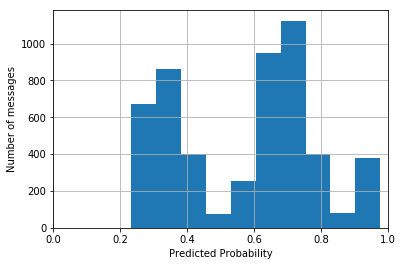

In [81]:
pr = logreg.predict_proba(X_test)
predict = logreg.predict(X_test)
plt.hist(pr[:,0])
plt.xlabel('Predicted Probability')
plt.ylabel('Number of messages')
plt.axis(xmin=0, xmax=1)
plt.grid();

In [82]:
#Testing the performance of this model.
accuracy_score(y_test, predict)

0.684149855907781

In [94]:
#Let's also do roc-auc-score
roc_ = roc_auc_score(y_test, pr[:,1])
roc_

0.7292522414622009

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

         0.0       0.71      0.76      0.73      2968
         1.0       0.65      0.58      0.61      2237

   micro avg       0.68      0.68      0.68      5205
   macro avg       0.68      0.67      0.67      5205
weighted avg       0.68      0.68      0.68      5205



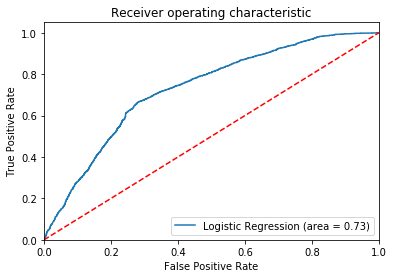

In [95]:
# Let's see the results visually
# logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
#Save results in a dataframe
results = pd.DataFrame({})